# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.36 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
state_sum = np.zeros((2,24))

In [6]:
rewards_l = []
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)

    while True:
        state_sum += states
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        rewards_l.append(rewards)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [7]:
# env.close()

In [8]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.1, sigma=0.5):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
        self.sigma *= 0.99
        self.sigma = max(0.05, self.sigma)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(1)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple(
            'Experience', 
            field_names=['state', 'action', 'reward', 'next_state', 'done']
        )
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
    
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
def hidden_init(layer):
    fan_in = layer.weight.data.size(0)
    lim = 1.0 / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    
    def __init__(self, state_size, action_size, seed, layers=[256, 128]) -> None:
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size*2, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

class Critic(nn.Module):
    
    def __init__(self, state_size, action_size, seed, layers=[256, 128]) -> None:
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fcs1 = nn.Linear(state_size*2, layers[0])
        self.fc2 = nn.Linear(layers[0] + action_size*2, layers[1])
        self.fc3 = nn.Linear(layers[1], 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        x = F.relu(self.fcs1(state))
        x = torch.cat([x, action], dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [11]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent:
    def __init__(self, state_size, action_size, random_seed, agent_id, memory=None) -> None:
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.agent_id = agent_id

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_opt = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_opt = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        self.soft_update(self.actor_local, self.actor_target, 1)
        self.soft_update(self.critic_local, self.critic_target, 1)
        
        self.noise = OUNoise((1, action_size), random_seed)
        
        self.memory = memory
        if self.memory is None:
            self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
        self.reset()

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        state, action, reward, next_state, done = experiences
        
        # critic
        action_next = self.actor_target(next_state)
#         print(action_next, action_next.shape)
#         print(action, action.shape)
        if self.agent_id == 0:
            action_next = torch.cat((action_next, action[:, 2:]), dim=-1)
        else:
            action_next = torch.cat((action[:, :2], action_next), dim=-1)
        
        Q_targets_next = self.critic_target(next_state, action_next)
        Q_targets = reward + (gamma * Q_targets_next * (1 - done))
        Q_expected = self.critic_local(state, action)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_opt.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_opt.step()

        # actor
        action_pred = self.actor_local(state)
        if self.agent_id == 0:
            action_pred = torch.cat((action_pred, action[:,2:]), dim=1)
        else:
            action_pred = torch.cat((action[:,:2], action_pred), dim=1)
        
        actor_loss = -self.critic_local(state, action_pred).mean()
        # Minimize the loss
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)

    def act(self, state, add_noise=True, noise_rate=0.0):
        """
        docstring
        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() #self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()
    
    def soft_update(self, local, target, tau):
        for target_param, local_param in zip (target.parameters(), local.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class MultiAgent:

    def __init__(self, state_size, action_size, random_seed) -> None:
        self.action_size = action_size
        self.noise_decay = 0.99
        self.min_noise = 0.05

        self.agent1 = Agent(state_size, action_size, random_seed, agent_id=0)
        self.agent2 = Agent(state_size, action_size, random_seed, agent_id=1)

    def act(self, state, add_noise=True):
        """
        docstring
        """
        state1 = np.reshape(state, (1, 48))
        state2 = state1.copy()

        action1 = self.agent1.act(state1, add_noise)
        action2 = self.agent2.act(state2, add_noise)

        actions = np.concatenate([action1, action2], axis=0).flatten()
        assert len(actions.shape) == 1
        return actions
    
    def step(self, state, action, reward, next_state, done, ep_i):
        self.agent1.step(state, action, reward[0], next_state, done[0])
        self.agent2.step(state, action, reward[1], next_state, done[1])

    def reset(self):
        self.agent1.reset()
        self.agent2.reset()

In [12]:
agent = MultiAgent(24, 2, 0)

In [13]:
def ddpg(n_episodes=1000, print_every=100, add_noise=True):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations
        state = np.reshape(state, (1, 48))

        score = np.zeros(2)
        while True:
            action = agent.act(state, add_noise=add_noise)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            next_state = np.reshape(next_state, (1, 48))
            reward = env_info.rewards
            done = env_info.local_done

            agent.step(state, action, reward, next_state, done, i_episode)
            state = next_state
            score += np.max(reward)
            if np.any(done):
                break
        max_score = np.max(score)
        scores_deque.append(max_score)
        scores.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent.agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent.agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent.agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 0.5: break
            
    return scores

# scores = ddpg(n_episodes=1000)

scores = ddpg(n_episodes=3000)

Episode 100	Average Score: 0.00200000
Episode 200	Average Score: 0.00000000
Episode 300	Average Score: 0.00400000
Episode 400	Average Score: 0.02100000
Episode 500	Average Score: 0.01100000
Episode 600	Average Score: 0.00100000
Episode 700	Average Score: 0.00100000
Episode 800	Average Score: 0.01200000
Episode 900	Average Score: 0.03900000
Episode 1000	Average Score: 0.07500000
Episode 1100	Average Score: 0.05690000
Episode 1200	Average Score: 0.08790000
Episode 1300	Average Score: 0.12200000
Episode 1400	Average Score: 0.11400000
Episode 1500	Average Score: 0.14100000
Episode 1600	Average Score: 0.17100000
Episode 1700	Average Score: 0.17000000
Episode 1800	Average Score: 0.16100000
Episode 1900	Average Score: 0.17580000
Episode 2000	Average Score: 0.24890000
Episode 2100	Average Score: 0.25700000
Episode 2200	Average Score: 0.06900000
Episode 2300	Average Score: 0.11800000
Episode 2400	Average Score: 0.25400000
Episode 2500	Average Score: 0.22690000
Episode 2600	Average Score: 0.2269

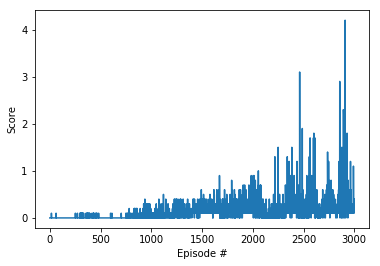

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
def ddpg(n_episodes=1000, print_every=100, add_noise=True):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        state = env_info.vector_observations
        state = np.reshape(state, (1, 48))

        score = np.zeros(2)
        while True:
            action = agent.act(state, add_noise=add_noise)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            next_state = np.reshape(next_state, (1, 48))
            reward = env_info.rewards
            done = env_info.local_done

            agent.step(state, action, reward, next_state, done, i_episode)
            state = next_state
            score += np.max(reward)
            if np.any(done):
                break
        max_score = np.max(score)
        scores_deque.append(max_score)
        scores.append(max_score)
        print('\rEpisode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.agent1.actor_local.state_dict(), 'checkpoint_actor1.pth')
        torch.save(agent.agent2.actor_local.state_dict(), 'checkpoint_actor2.pth')
        torch.save(agent.agent1.critic_local.state_dict(), 'checkpoint_critic1.pth')
        torch.save(agent.agent2.critic_local.state_dict(), 'checkpoint_critic2.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.8f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 0.5: break
            
    return scores

# scores = ddpg(n_episodes=1000)

scores_ = ddpg(n_episodes=3000)

Episode 100	Average Score: 0.22200000
Episode 200	Average Score: 0.38900001
Episode 300	Average Score: 0.35090001
Episode 324	Average Score: 0.50200001

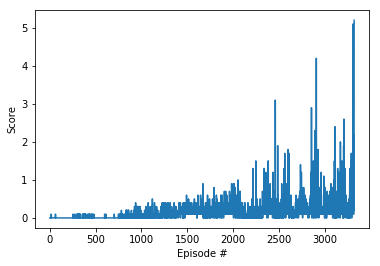

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores) + len(scores_)), scores + scores_)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()